Warning message:
: package 'forecast' was built under R version 3.2.5Loading required package: zoo
Warning message:
: package 'zoo' was built under R version 3.2.5
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
Warning message:
: package 'timeDate' was built under R version 3.2.3This is forecast 7.1 

Warning message:
: package 'car' was built under R version 3.2.5

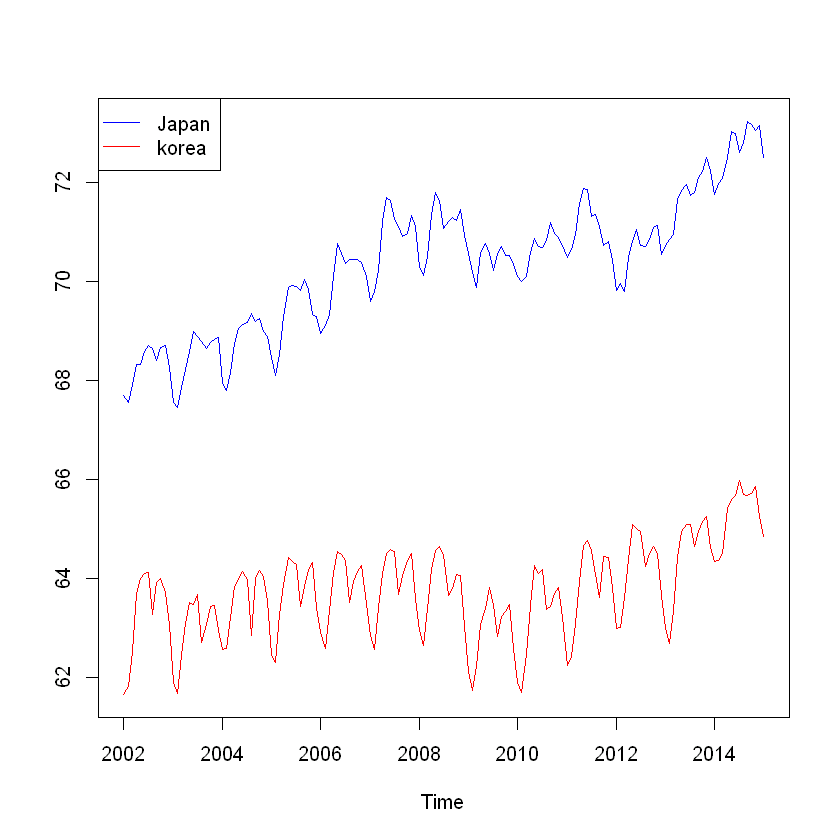

In [2]:
library(forecast)
library(car)
options(scipen=999)

jp_data <- read.csv2("japan_employment.csv")
kr_data <- read.csv2("korea_employment.csv")
jp_ts <- ts(jp_data$Value, start=c(2002, 01), end=c(2015, 01), frequency=12)
kr_ts <- ts(kr_data$Value, start=c(2002, 01), end=c(2015, 01), frequency=12)

ts.plot(jp_ts, kr_ts, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Japan","korea"),
        col=c("blue","red"), lwd=1, 
        pch=c(NA,NA))

[1] "Durbin watson > 1"


[1] 1.253902

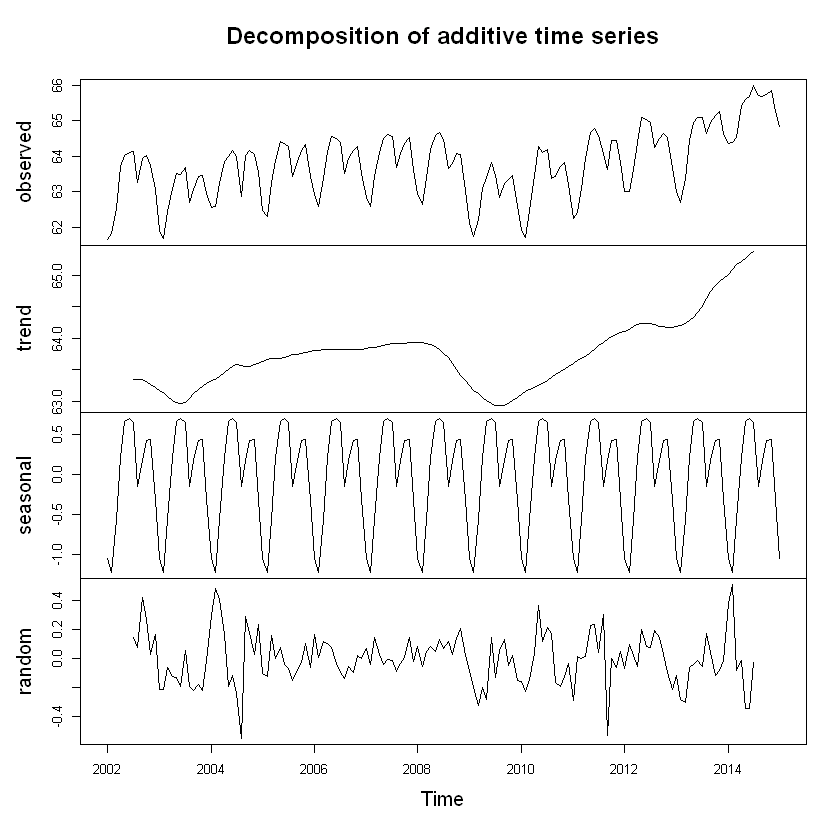

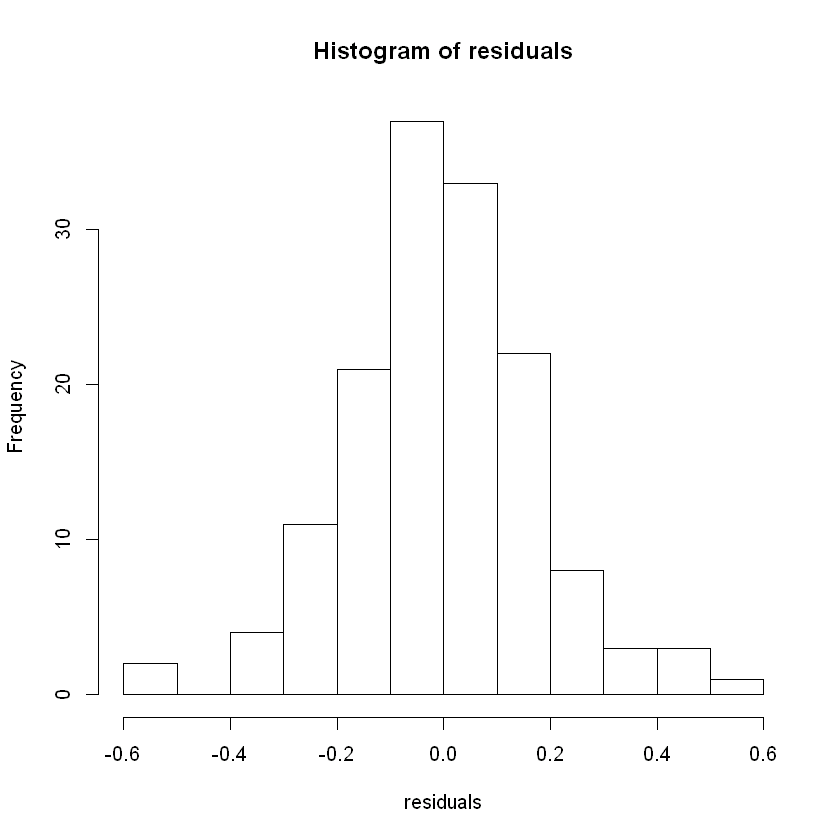

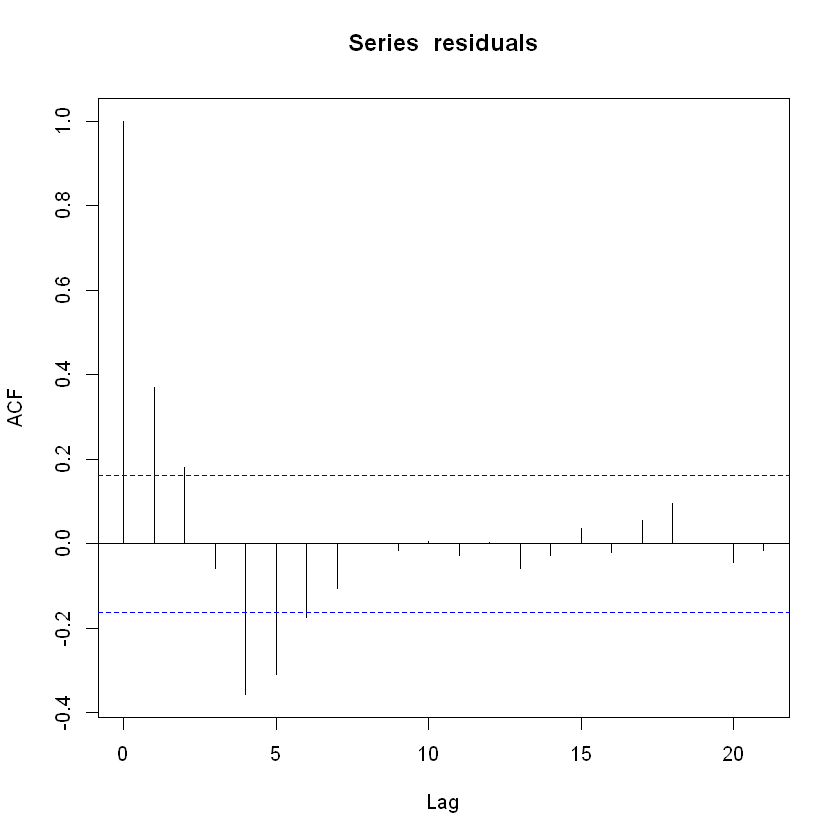

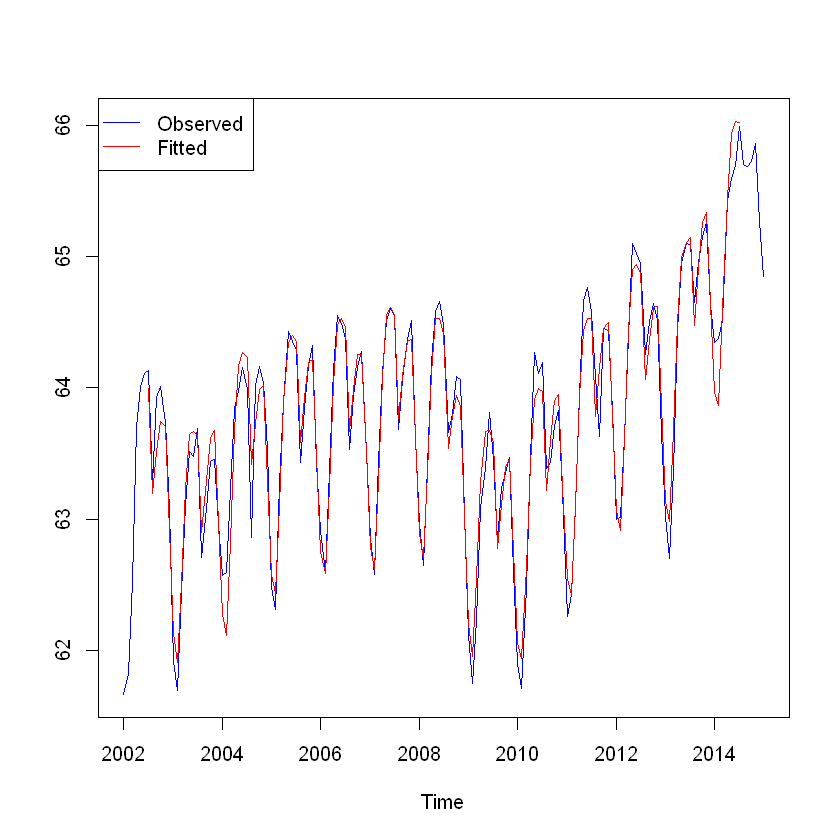

In [29]:

kr_dec <- decompose(kr_ts, type = "additive")
plot(kr_dec)
residuals <- na.omit(as.vector(kr_dec$random))
print("Durbin watson > 1")
durbinWatsonTest(as.vector(residuals))


hist(residuals)
acf(residuals)


fitted <- kr_dec$trend + kr_dec$seasonal
ts.plot(kr_dec$x, fitted, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Observed","Fitted"),
        col=c("blue","red"), lwd=1, 
        pch=c(NA,NA))

[1] "Durbin watson < 1"


[1] 0.9222358

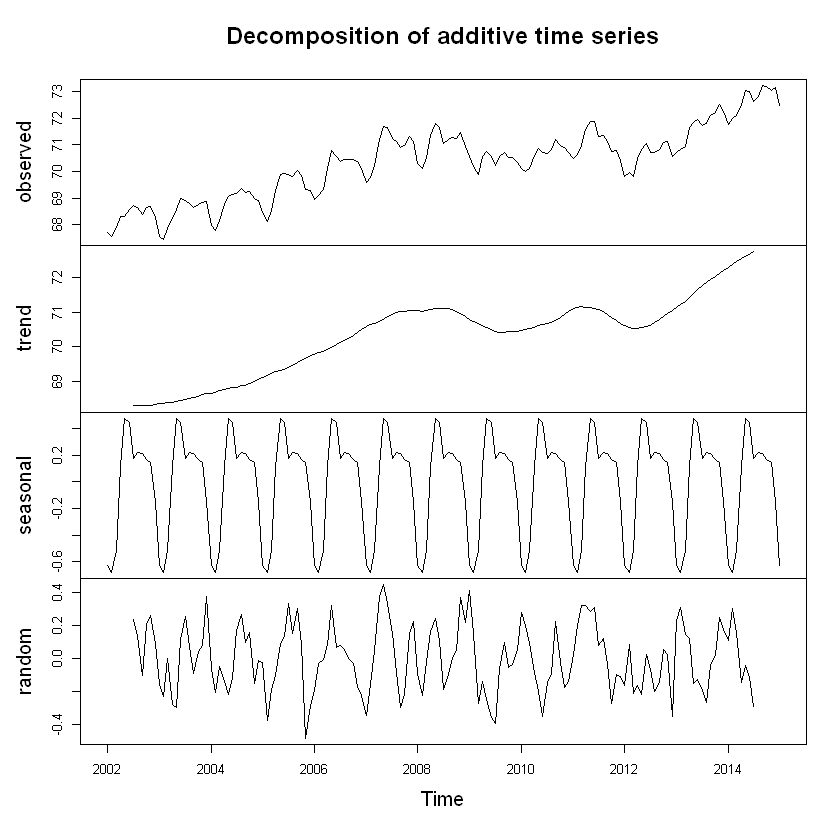

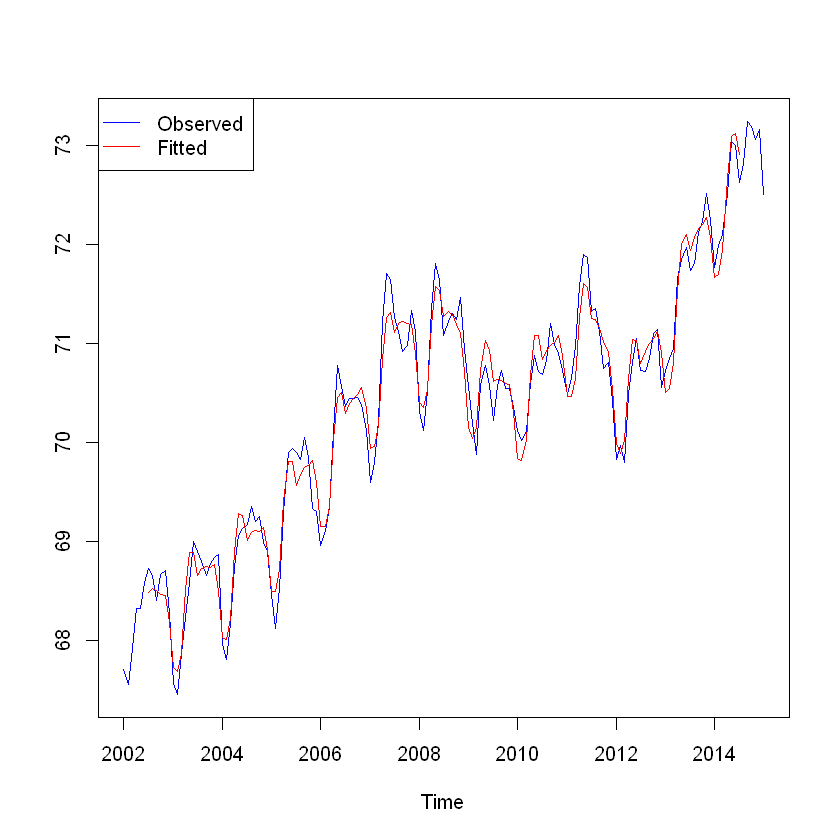

In [4]:
jp_dec <- decompose(jp_ts, type = "additive")
plot(jp_dec)
residuals <- na.omit(as.vector(jp_dec$random))
print("Durbin watson < 1")
durbinWatsonTest(as.vector(residuals))

fitted <- jp_dec$trend + jp_dec$seasonal
ts.plot(jp_dec$x, fitted, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Observed","Fitted"),
        col=c("blue","red"), lwd=1, 
        pch=c(NA,NA))


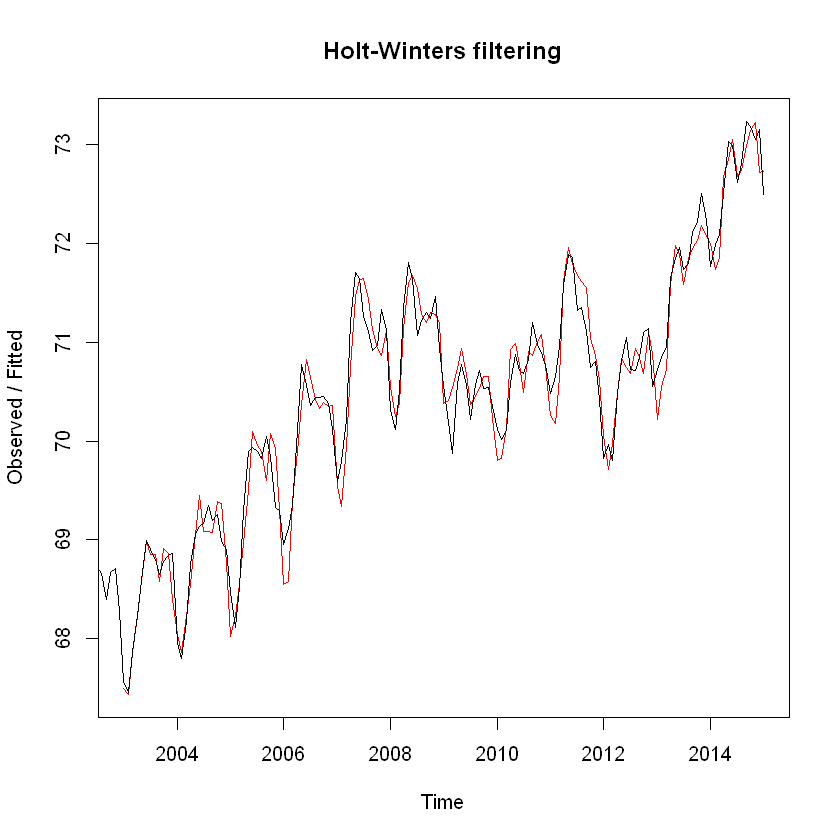

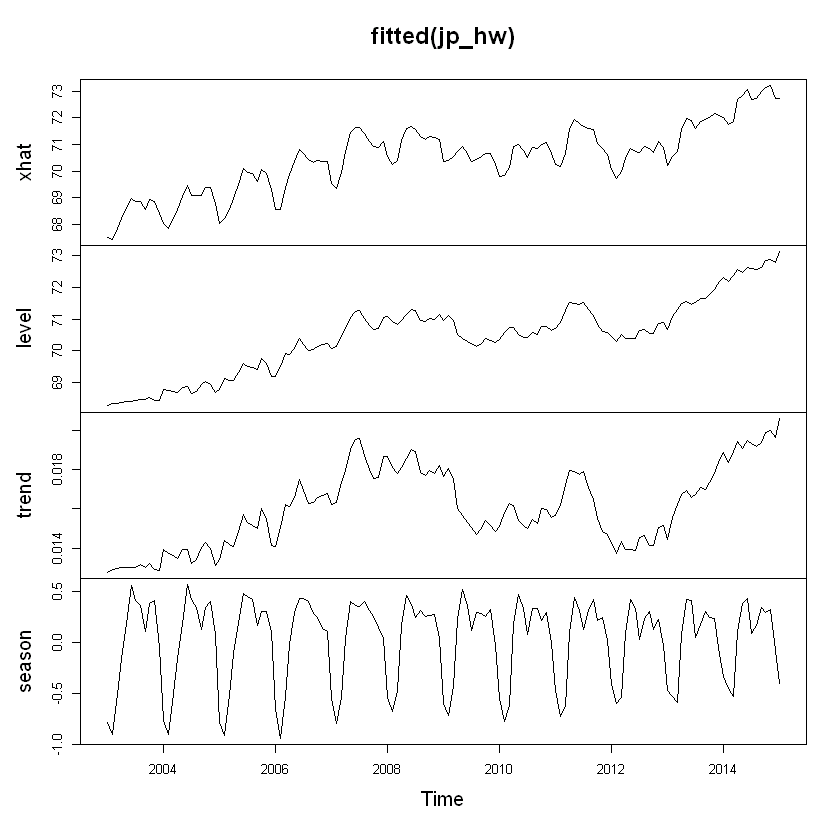

In [5]:
jp_hw <- HoltWinters(jp_ts)
plot(jp_hw)
plot(fitted(jp_hw))

Warning message:
In abline(trend, col = "green"): only using the first two of 4 regression coefficients

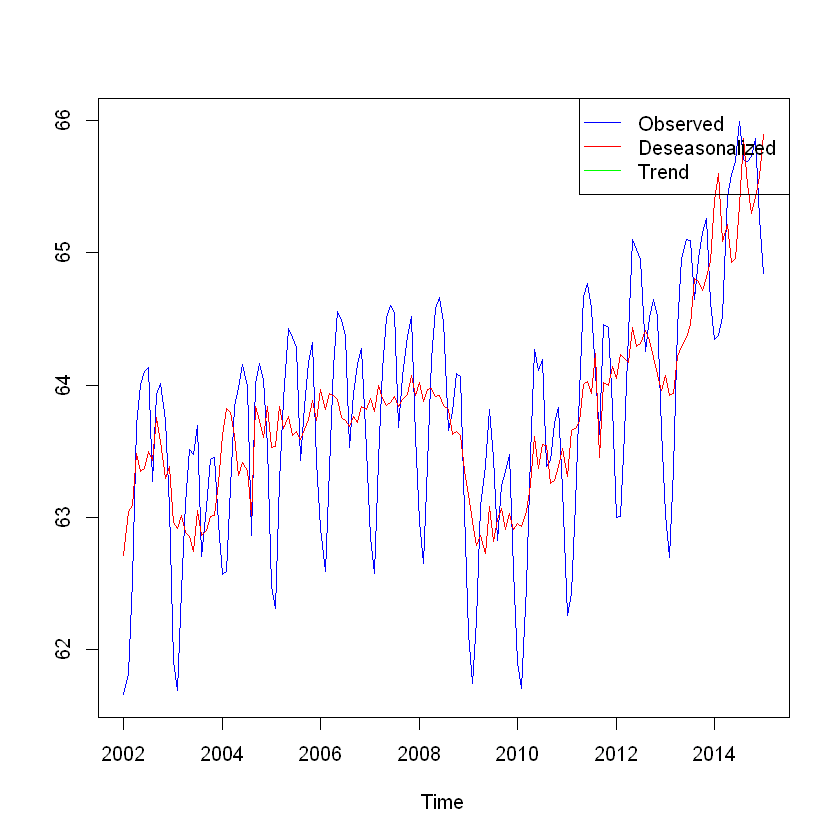

[1] 0.403662

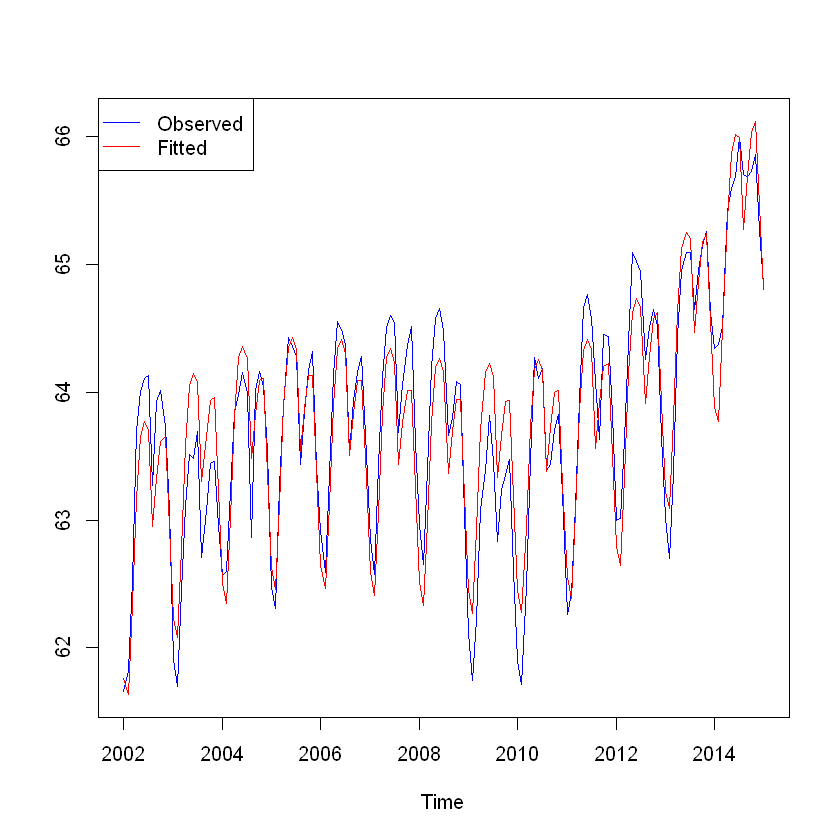

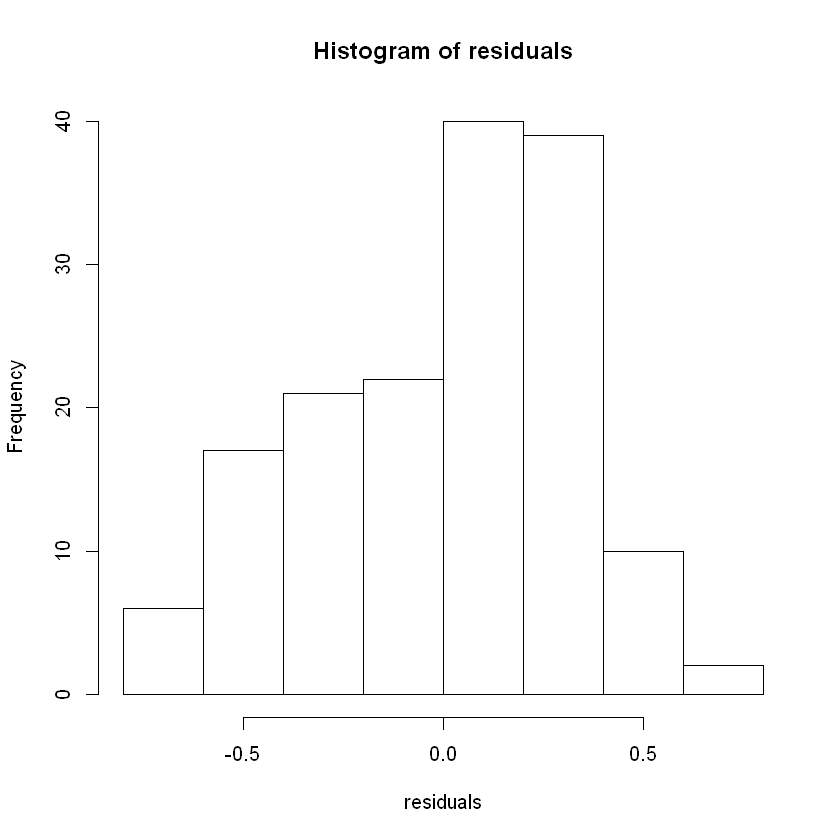


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = kr_dec, h = 12, alpha = 0.5, beta = 0.1) 

  Smoothing parameters:
    alpha = 0.5 
    beta  = 0.1 

  Initial states:
    l = 62.8236 
    b = 0.0854 

  sigma:  0.2161

     AIC     AICc      BIC 
316.7747 316.8526 322.8872 

Error measures:
                        ME      RMSE       MAE          MPE      MAPE      MASE
Training set -0.0008812385 0.2160976 0.1609856 -0.001880497 0.2520567 0.3756353
                  ACF1
Training set 0.2317466

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Feb 2015       65.80852 65.53158 66.08546 65.38497 66.23206
Mar 2015       65.88010 65.54205 66.21815 65.36310 66.39710
Apr 2015       65.95169 65.54751 66.35587 65.33355 66.56983
May 2015       66.02328 65.54842 66.49813 65.29705 66.74950
Jun 2015       66.09486 65.54515 66.64457 65.25415 66.93557
Jul 2015       66.16645 65.53797 66.79493 65.20528 67.12762
Aug 2015       66.23804 65.52710 

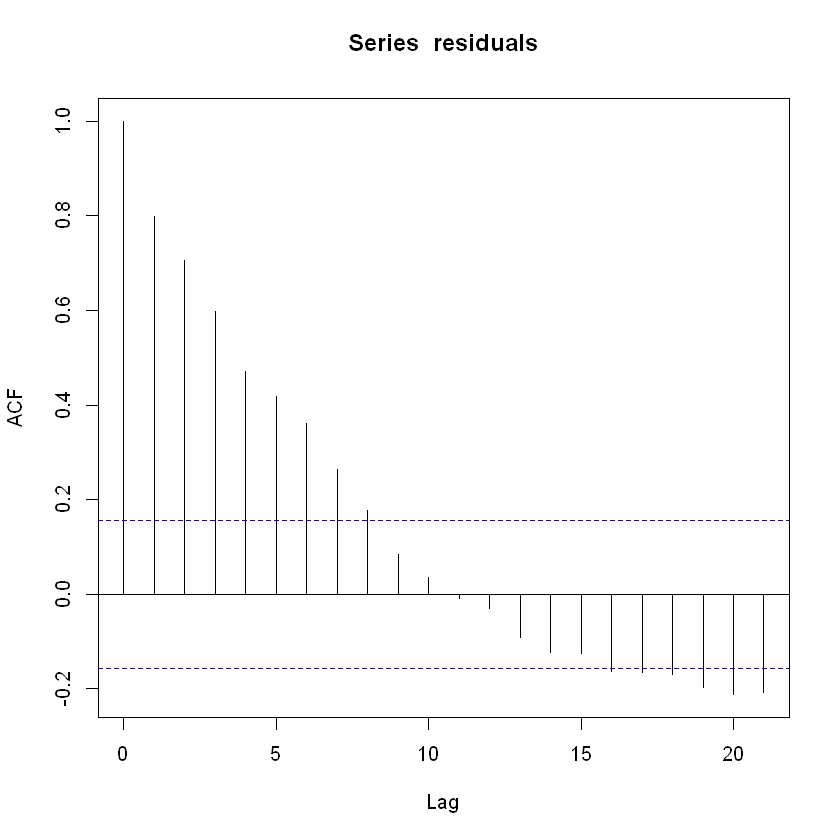

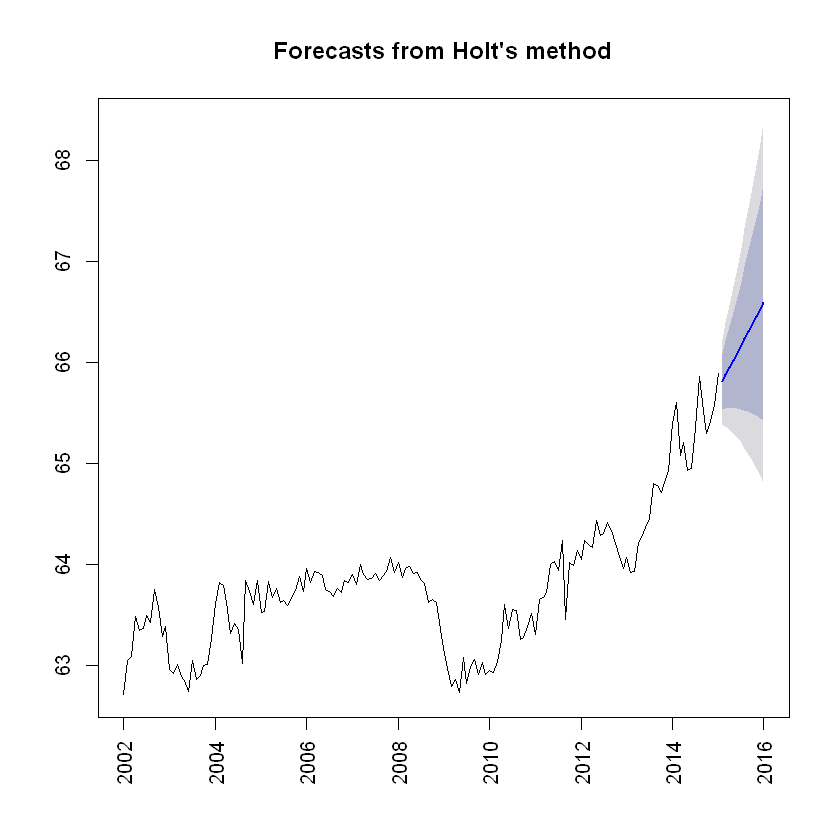

In [28]:
#Calculate moving average
kr_data$Seasonal <- ma(kr_data$Value, 12)
kr_data$Seasonal <- ma(kr_data$Seasonal, 4, centre = TRUE)


#Calculate rough seasonal component
kr_data$Seasonal <- kr_data$Value - kr_data$Seasonal
kr_data$Month <- sapply(kr_data$Date, function(x) {format(as.Date(x), "%m")})
kr_m_s <- aggregate(kr_data$Seasonal ~ kr_data$Month, FUN = mean)


colnames(kr_m_s) <- c("Month", "Seasonal")

#Plot seasonal components
#plot(ts(rep(kr_m_s$Seasonal, 11), start=c(2002, 01), end=c(2015, 01), frequency=12))

#Calculate how much bigger or smaller the rough component is
fix_ratio <- sum(kr_m_s$Seasonal) / 12

#Fix the rough seasonal component
kr_m_s$Seasonal <- kr_m_s$Seasonal - fix_ratio

kr_data$Seasonal <- c(rep(kr_m_s$Seasonal, 13), kr_m_s$Seasonal[1])

kr_data$Deseasonalized <- kr_data$Value - kr_data$Seasonal

kr_dec <- ts(kr_data$Deseasonalized, start=c(2002, 01), end=c(2015, 01), frequency=12)

ts.plot(kr_ts, kr_dec, gpars= list(col = c("blue", "red")))

legend( x="topright", 
        legend=c("Observed","Deseasonalized", "Trend"),
        col=c("blue","red","green"), lwd=1, 
        pch=c(NA,NA))

#Trend
#trend <- lm(kr_data$Deseasonalized ~ index(kr_dec))
trend <- lm(kr_data$Deseasonalized ~ poly(1:157, 3, raw=TRUE))
kr_data$Trend <- trend$fit
abline(trend ,col="green")

fitted <- kr_data$Trend + kr_data$Seasonal
ts.plot(kr_ts, fitted, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Observed","Fitted"),
        col=c("blue","red"), lwd=1, 
        pch=c(NA,NA))


residuals <- kr_data$Value - fitted
durbinWatsonTest(residuals)

hist(residuals)
acf(residuals)

#Predict exponetial smoothing
kr_ts_pred_holt <- holt(kr_dec, alpha=0.5, beta=0.1, h = 12)
summary(kr_ts_pred_holt)
plot(kr_ts_pred_holt, xaxt="n")
axis(1, at = c(2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016), las=2)


[1] 0.0009479147

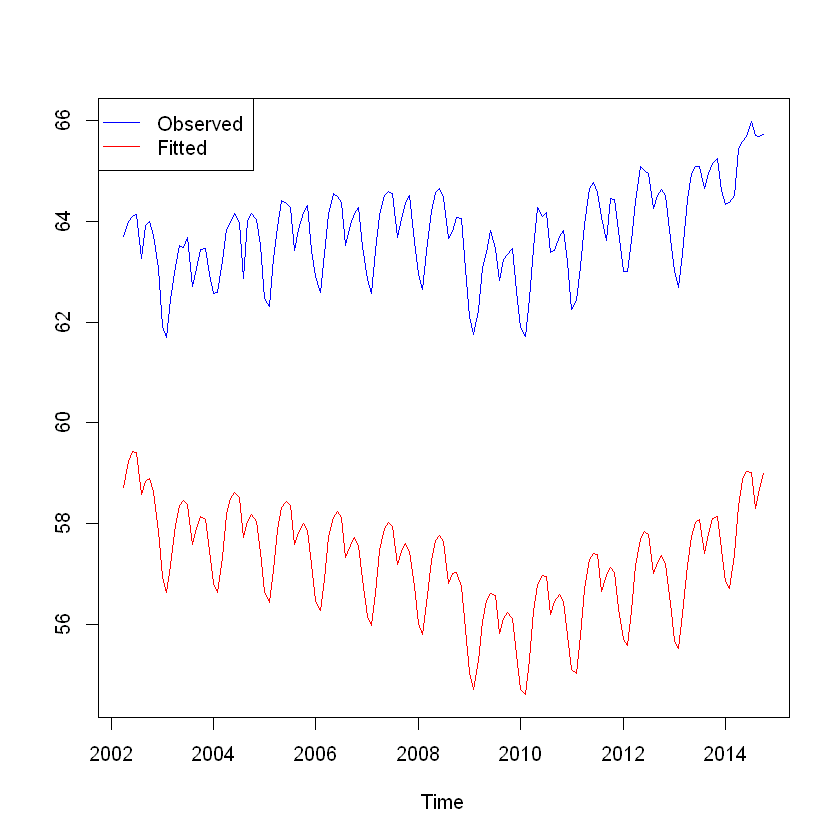

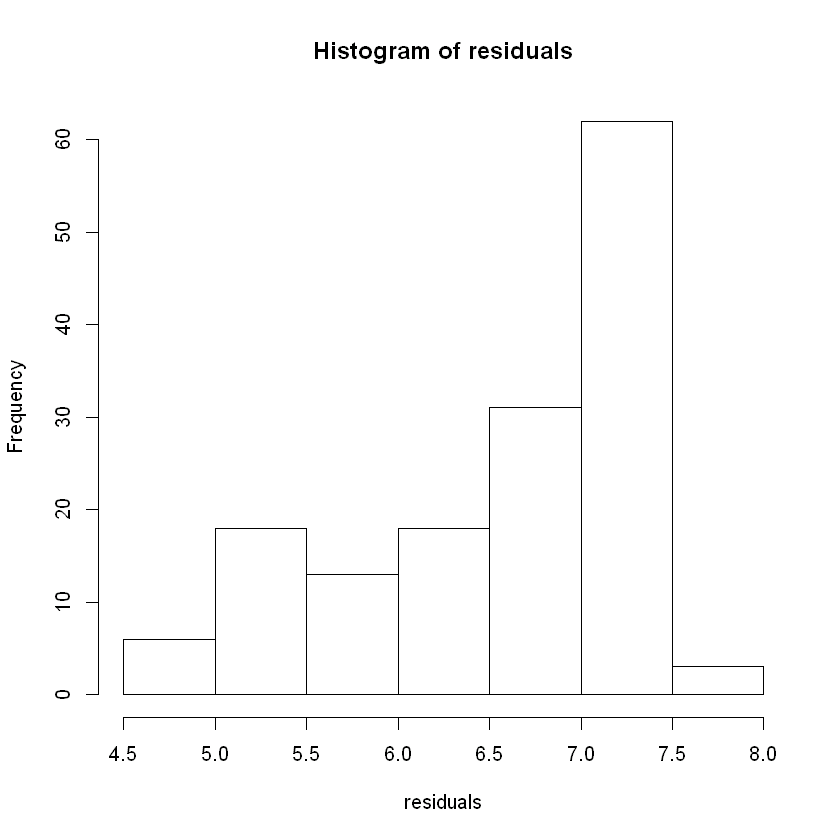

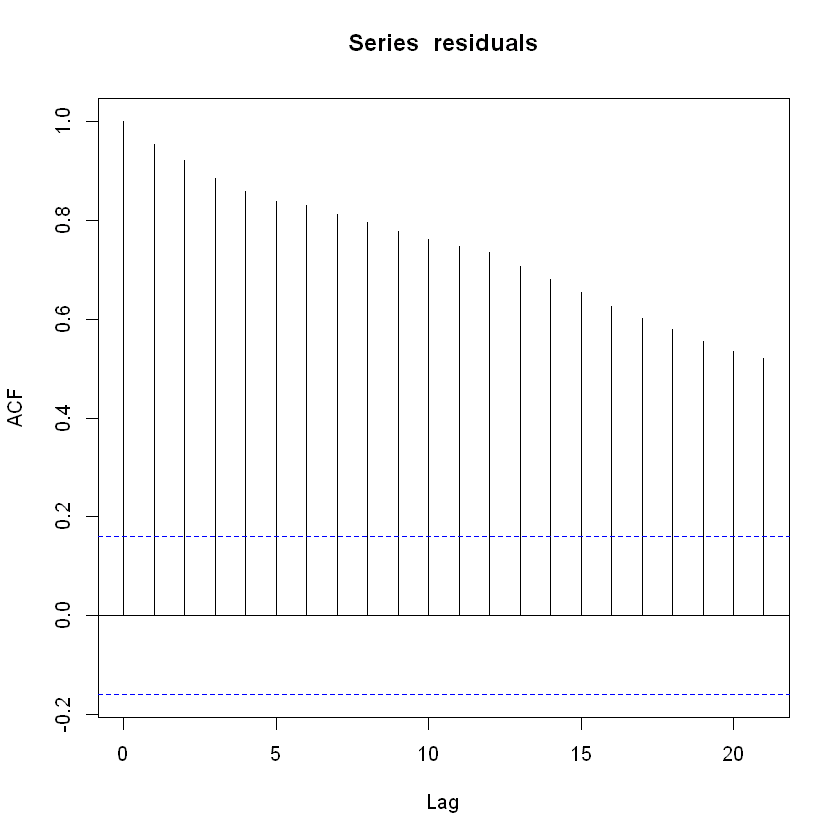

In [36]:


#Cyklisk
kr_data_C <- kr_data
kr_data_C$Clir <- kr_data_C$Value - fitted
kr_data_C$Cl <- ma(kr_data_C$Clir, 7)
kr_data_C <- na.omit(kr_data_C)
kr_data_C$Clir <- kr_data_C$Clir - kr_data_C$Cl


fitted <- kr_data_C$Trend + kr_data_C$Seasonal + kr_data_C$Cl
fitted_ts <- ts(fitted, start=c(2002, 04), end=c(2014, 10), frequency=12)
kr_dec_c_ts <- ts(kr_data_C$Value, start=c(2002, 04), end=c(2014, 10), frequency=12)
ts.plot(kr_dec_c_ts, fitted_ts, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Observed","Fitted"),
        col=c("blue","red"), lwd=1, 
        pch=c(NA,NA))

residuals <- kr_data_C$Value - fitted

durbinWatsonTest(residuals)

hist(residuals)
acf(residuals)

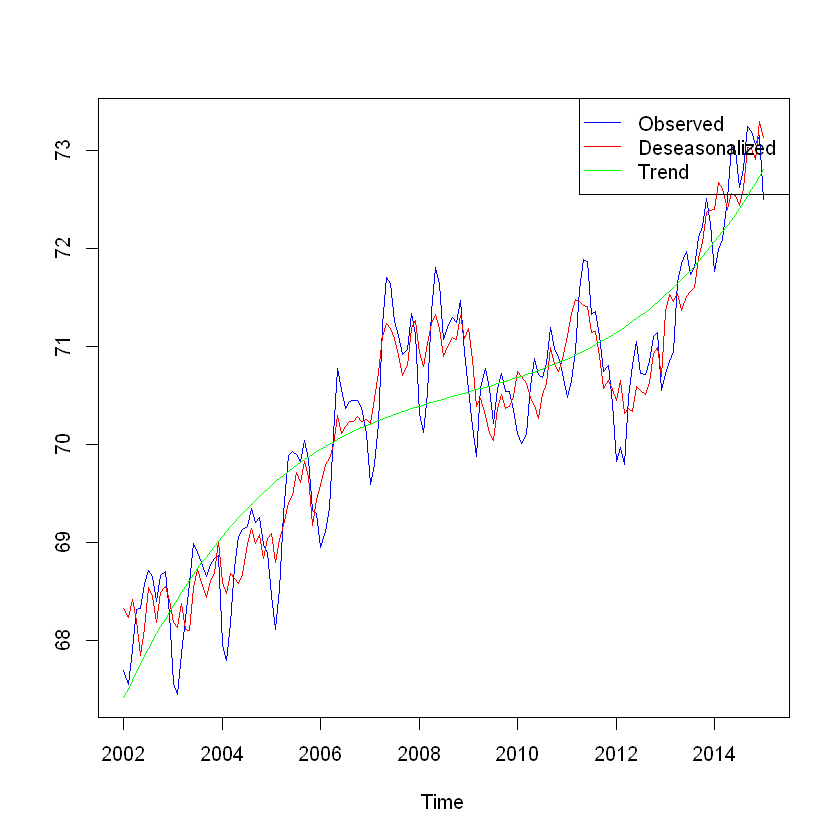

[1] 0.1951601

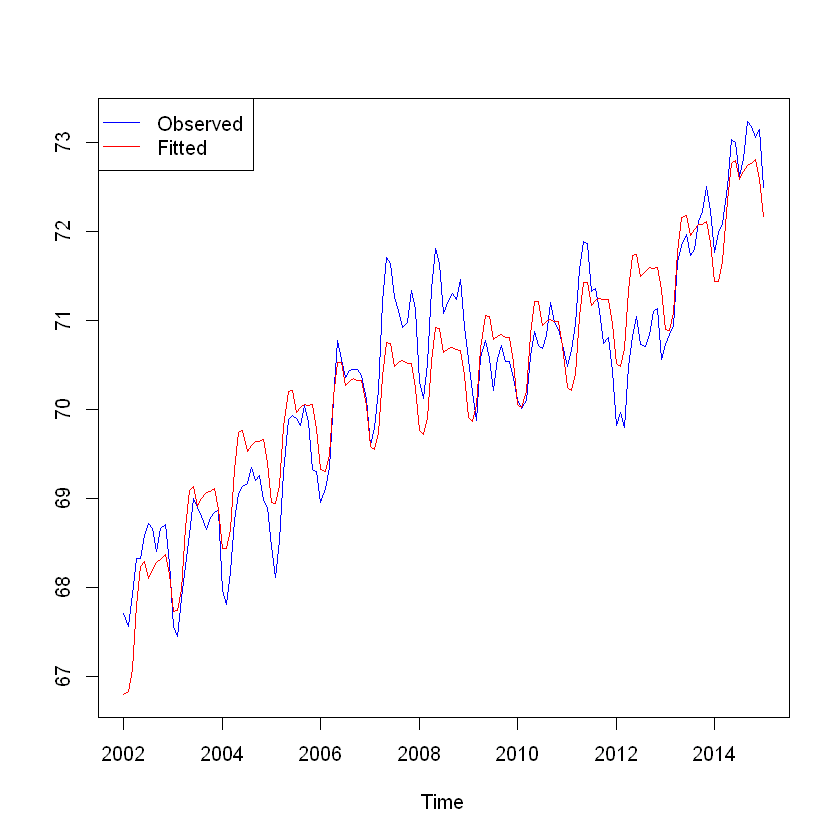

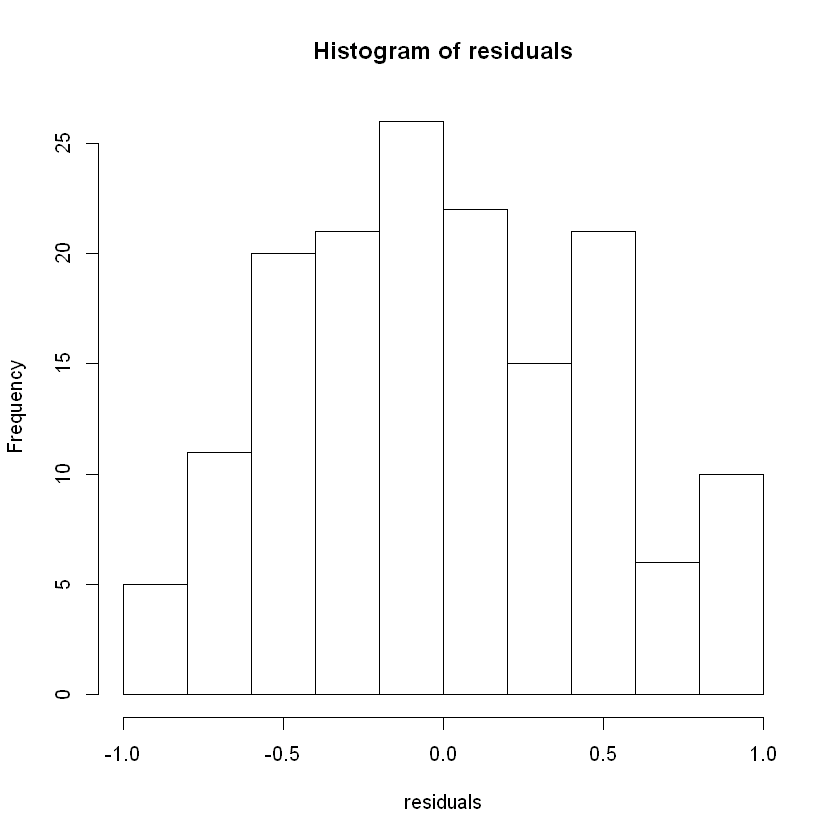


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(x = jp_dec, h = 12, alpha = 0.5, beta = 0.1) 

  Smoothing parameters:
    alpha = 0.5 
    beta  = 0.1 

  Initial states:
    l = 68.2859 
    b = -0.0041 

  sigma:  0.234

     AIC     AICc      BIC 
341.8147 341.8926 347.9272 

Error measures:
                      ME      RMSE       MAE         MPE      MAPE      MASE
Training set 0.005452148 0.2340361 0.1910114 0.007446972 0.2715838 0.3178581
                  ACF1
Training set 0.3941119

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Feb 2015       73.27727 72.97734 73.57720 72.81856 73.73597
Mar 2015       73.35876 72.99265 73.72487 72.79884 73.91868
Apr 2015       73.44025 73.00252 73.87798 72.77080 74.10970
May 2015       73.52174 73.00747 74.03601 72.73523 74.30825
Jun 2015       73.60323 73.00789 74.19858 72.69274 74.51373
Jul 2015       73.68473 73.00408 74.36537 72.64376 74.72569
Aug 2015       73.76622 72.99627 74.536

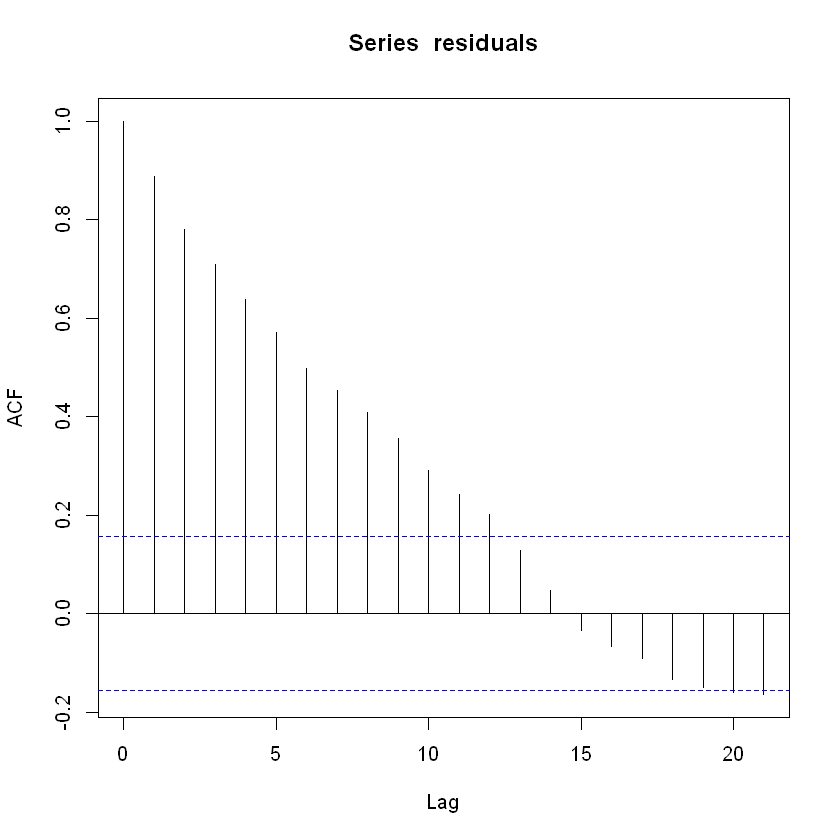

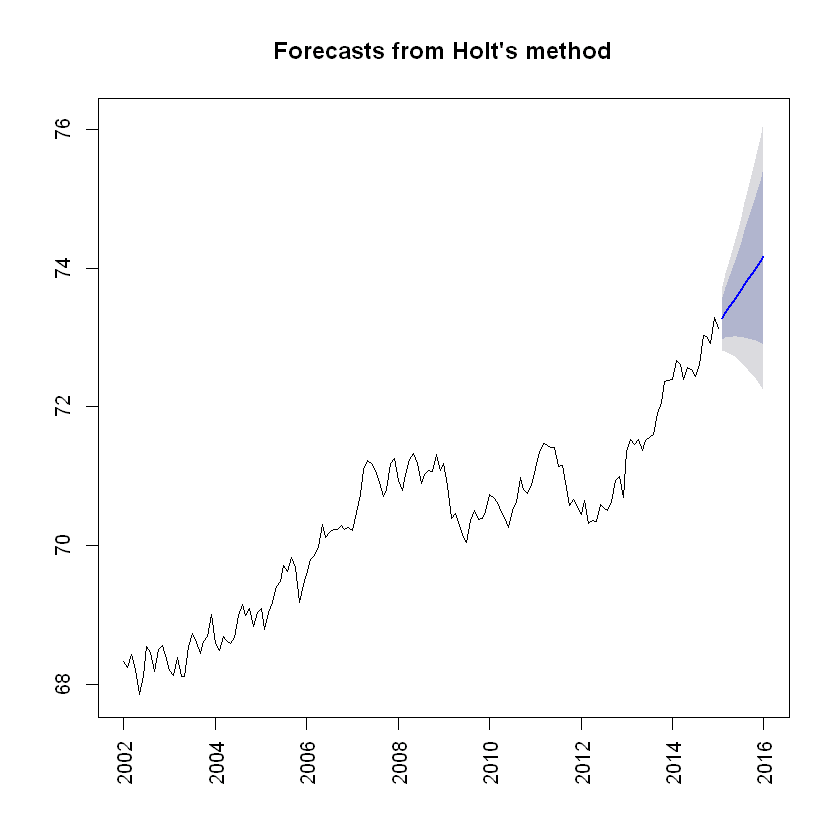

In [91]:
#Calculate moving average
jp_data$Seasonal <- ma(jp_data$Value, 12)
jp_data$Seasonal <- ma(jp_data$Seasonal, 4, centre = TRUE)


#Calculate rough seasonal component
jp_data$Seasonal <- jp_data$Value - jp_data$Seasonal
jp_data$Month <- sapply(jp_data$Date, function(x) {format(as.Date(x), "%m")})
jp_m_s <- aggregate(jp_data$Seasonal ~ jp_data$Month, FUN = mean)


colnames(jp_m_s) <- c("Month", "Seasonal")

#Plot seasonal components
#plot(ts(rep(kr_m_s$Seasonal, 11), start=c(2002, 01), end=c(2015, 01), frequency=12))

#Calculate how much bigger or smaller the rough component is
fix_ratio <- sum(jp_m_s$Seasonal) / 12

#Fix the rough seasonal component
jp_m_s$Seasonal <- jp_m_s$Seasonal - fix_ratio

jp_data$Seasonal <- c(rep(jp_m_s$Seasonal, 13), jp_m_s$Seasonal[1])

jp_data$Deseasonalized <- jp_data$Value - jp_data$Seasonal

jp_dec <- ts(jp_data$Deseasonalized, start=c(2002, 01), end=c(2015, 01), frequency=12)

ts.plot(jp_ts, jp_dec, gpars= list(col = c("blue", "red")))

legend( x="topright", 
        legend=c("Observed","Deseasonalized", "Trend"),
        col=c("blue","red","green"), lwd=1, 
        pch=c(NA,NA))

#Trend
#trend <- lm(kr_data$Deseasonalized ~ index(kr_dec))
trend <- lm(jp_data$Deseasonalized ~ poly(1:157, 3, raw=TRUE))
jp_data$Trend <- trend$fit

trend <- ts(trend$fit, start=c(2002, 01), end=c(2015, 01), frequency=12)
lines(trend ,col="green")

fitted <- jp_data$Trend + jp_data$Seasonal
ts.plot(jp_ts, fitted, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Observed","Fitted"),
        col=c("blue","red"), lwd=1, 
        pch=c(NA,NA))


residuals <- jp_data$Value - fitted
durbinWatsonTest(residuals)

hist(residuals)
acf(residuals)

#Predict exponetial smoothing
jp_ts_pred_holt <- holt(jp_dec, alpha=0.5, beta=0.1, h = 12)
summary(jp_ts_pred_holt)
plot(jp_ts_pred_holt, xaxt="n")
axis(1, at = c(2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016), las=2)



Call:
lm(formula = jp_data_C$Deseasonalized ~ poly(1:153, 3, raw = TRUE))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7957 -0.3316 -0.1006  0.3896  0.7804 

Coefficients:
                                 Estimate    Std. Error t value
(Intercept)                 67.3469909388  0.1407900641 478.350
poly(1:153, 3, raw = TRUE)1  0.0936484033  0.0078916353  11.867
poly(1:153, 3, raw = TRUE)2 -0.0009893113  0.0001188676  -8.323
poly(1:153, 3, raw = TRUE)3  0.0000039389  0.0000005075   7.762
                                        Pr(>|t|)    
(Intercept)                 < 0.0000000000000002 ***
poly(1:153, 3, raw = TRUE)1 < 0.0000000000000002 ***
poly(1:153, 3, raw = TRUE)2   0.0000000000000507 ***
poly(1:153, 3, raw = TRUE)3   0.0000000000012354 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4247 on 149 degrees of freedom
Multiple R-squared:  0.8831,	Adjusted R-squared:  0.8808 
F-statistic: 375.3 on 3 and 149 DF,  p-value: <

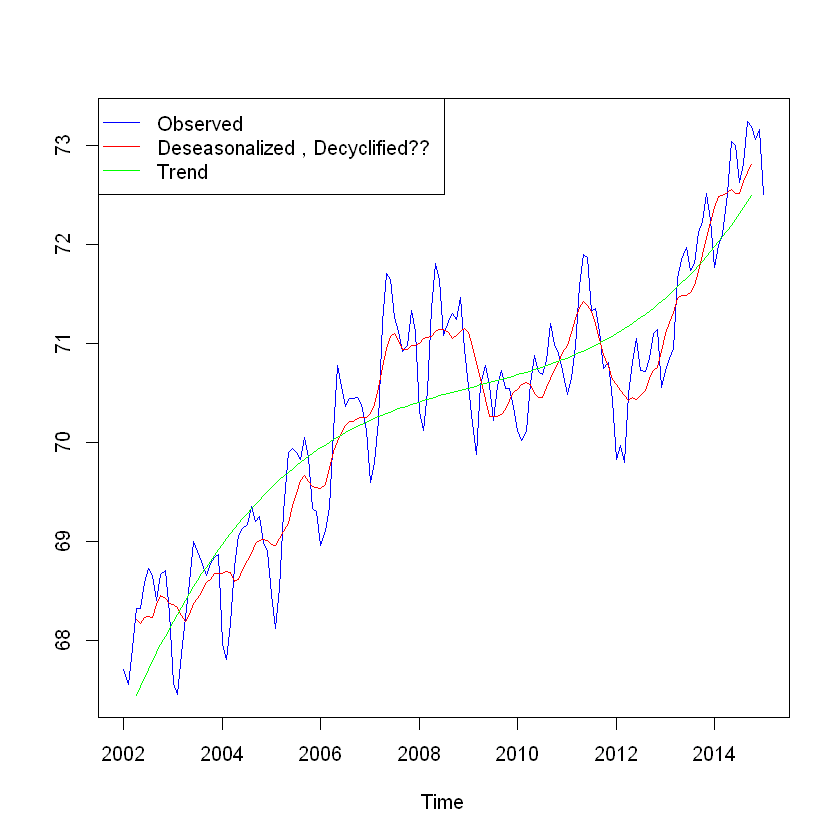

[1] 1.766056

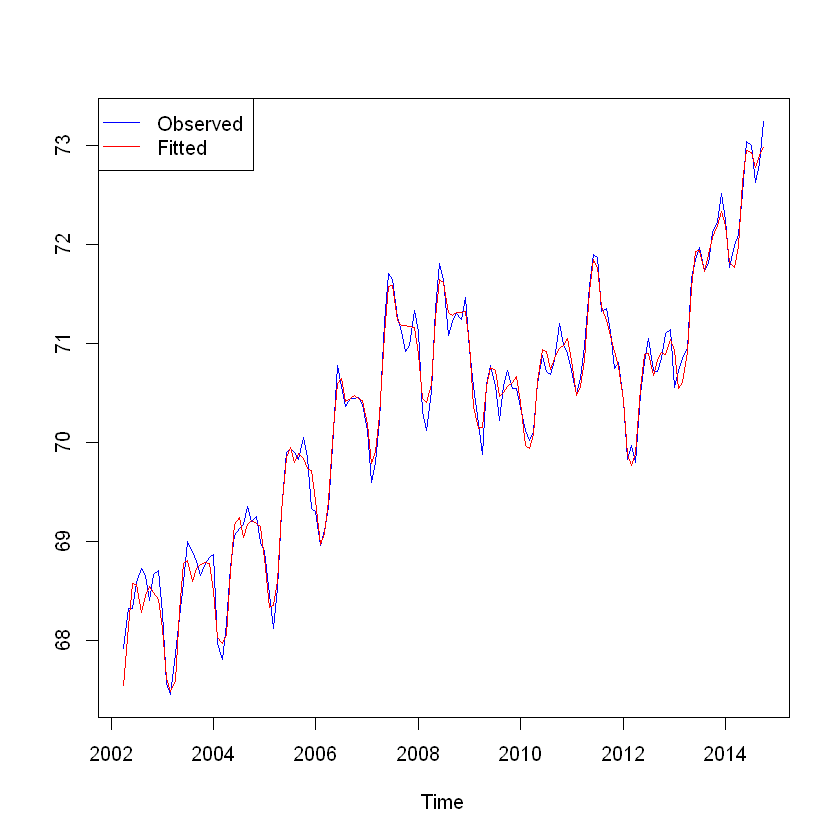

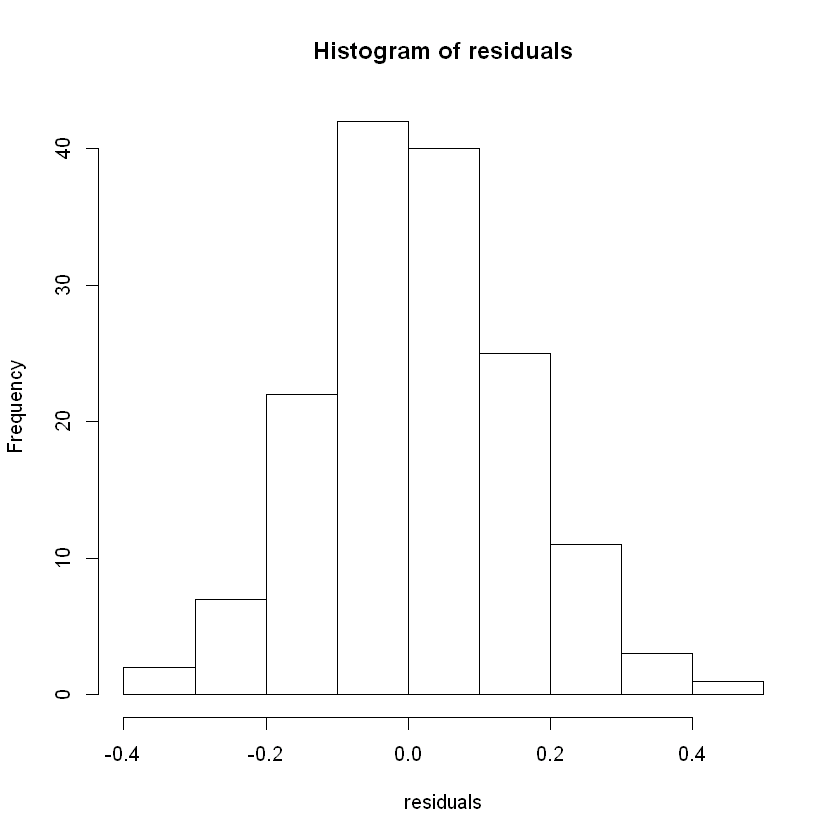

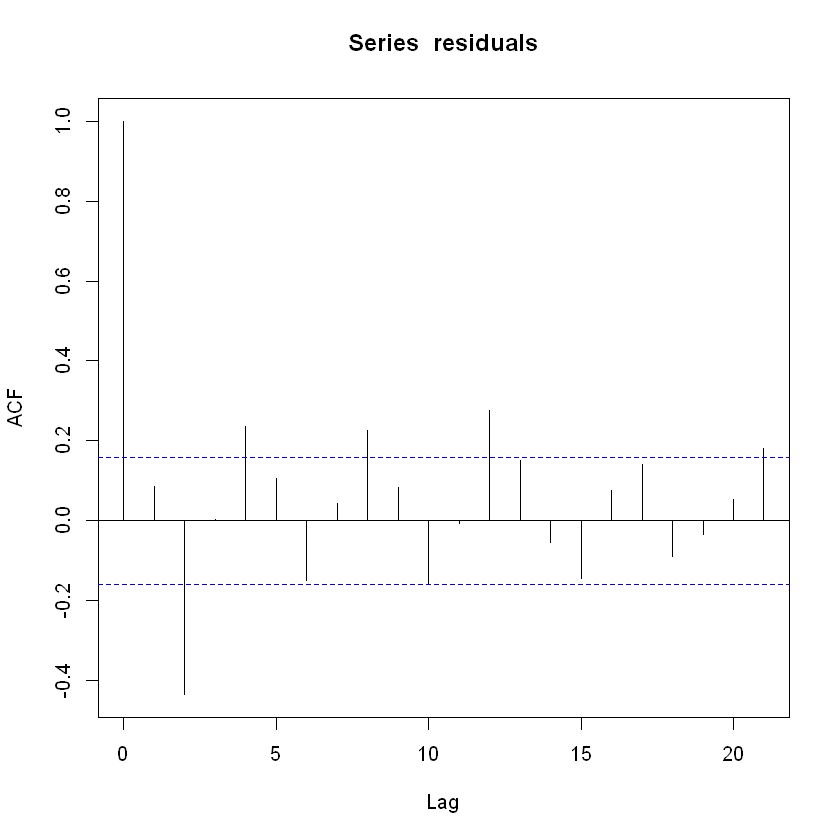

In [126]:
#Cyklisk
jp_data_C <- jp_data
jp_data_C$Clir <- jp_data_C$Value - fitted
jp_data_C$Cl <- ma(jp_data_C$Clir, 5)
jp_data_C <- na.omit(jp_data_C)
jp_data_C$Clir <- jp_data_C$Clir - jp_data_C$Cl

jp_data_C$Deseasonalized <- jp_data_C$Value - (jp_data_C$Seasonal + jp_data_C$Clir)

jp_c_dec <- ts(jp_data_C$Deseasonalized, start=c(2002, 04), end=c(2014, 10), frequency=12)
jp_c_ts <- ts(jp_data_C$Deseasonalized, start=c(2002, 04), end=c(2014, 10), frequency=12)

ts.plot(jp_ts, jp_c_dec, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Observed","Deseasonalized , Decyclified??", "Trend"),
        col=c("blue","red","green"), lwd=1, 
        pch=c(NA,NA))

trend <- lm(jp_data_C$Deseasonalized ~ poly(1:153, 3, raw=TRUE))
jp_data_C$Trend <- trend$fit
summary(trend)

trend <- ts(trend$fit, start=c(2002, 04), end=c(2014, 10), frequency=12)
lines(trend ,col="green")

fitted_c <- jp_data_C$Trend + jp_data_C$Seasonal + jp_data_C$Cl
fitted_ts <- ts(fitted_c, start=c(2002, 04), end=c(2014, 10), frequency=12)
jp_dec_c_ts <- ts(jp_data_C$Value, start=c(2002, 04), end=c(2014, 10), frequency=12)
ts.plot(jp_dec_c_ts, fitted_ts, gpars= list(col = c("blue", "red")))

legend( x="topleft", 
        legend=c("Observed","Fitted"),
        col=c("blue","red"), lwd=1, 
        pch=c(NA,NA))





residuals <- jp_data_C$Value - fitted_c

durbinWatsonTest(residuals)

hist(residuals)
acf(residuals)

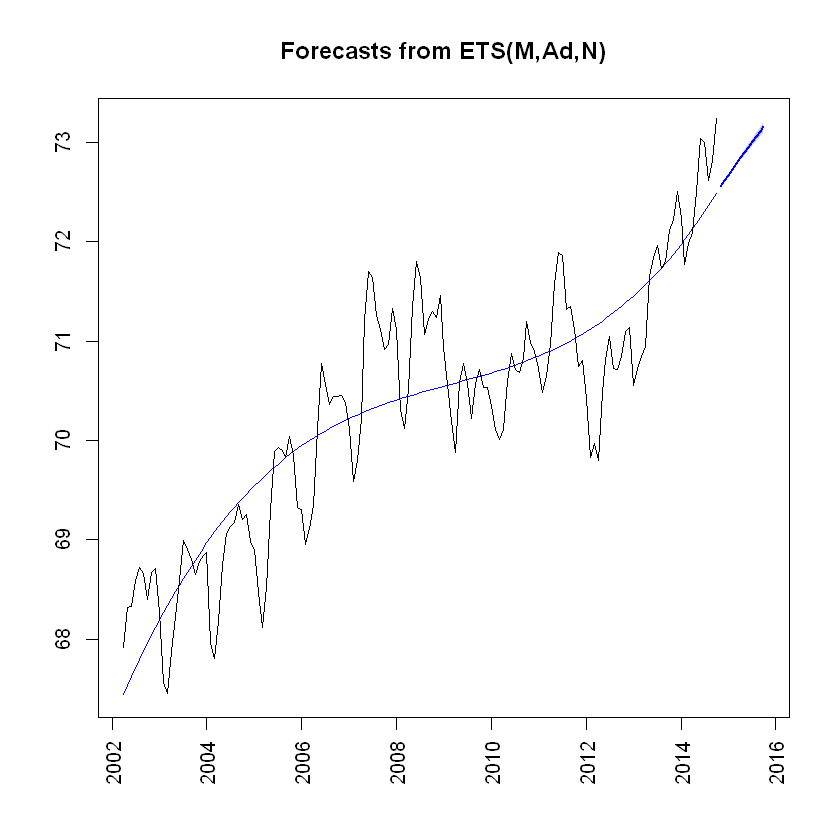

In [123]:
plot(forecast(trend, h=12), xaxt="n", col="blue")
lines(jp_dec_c_ts, col="black")
axis(1, at = c(2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016), las=2)